# Welding Defect Classification

In this notebook, we build a deep learning model to classify images of welds as defective or not defective. We make use of a pre-trained model with transfer learning.

### Load Libraries

Load necessary libraries, and optionally install missing requirements.  If any other needed libraries are not installed, please install them with `!pip install <library name>`.

We also print out some data about the environment and set the seed.

In [6]:
# # Install the following libraries with pip, if not already available:
!pip install matplotlib
!pip install tf2onnx

import os

import numpy as np
from numpy.random import seed
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import applications, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, accuracy_score
from PIL import Image

import tf2onnx
import onnx

from time import perf_counter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [7]:
# Print library versions
print('numpy:', np.__version__)
print('tensorflow:', tf.__version__)

# Print backend and image data format
print('backend:', K.backend())
print('image data format:', K.image_data_format())

# Set seed 
seed(1)
tf.compat.v1.set_random_seed(2)

numpy: 1.19.5
tensorflow: 2.6.2
backend: tensorflow
image data format: channels_last


### Define functions and set environment and model training variables

In [8]:
def plot_history(model_hist):
    '''Given model training data, plot the model training history.'''
    plt.plot(model_hist.history['accuracy'])
    plt.plot(model_hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return

def print_performance(y_truth, y_pred_class):
    '''Given ground truth and predicted labels, print the performance of the model:
        - Confusion Matrix
        - Accuracy
        - Matthews Correlation Coefficient
    '''
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_truth, y_pred_class))

    print("Accuracy: {0:.4f}".format(accuracy_score(y_truth, y_pred_class)))
    print("MCC:      {0:.4f}".format(matthews_corrcoef(y_truth, y_pred_class)))
    return


def list_files(path):
    '''List files recursively for a given path. Use full path for each file.'''
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(r, file))
    return files

def print_pil_img_info(an_img_path):
    '''Print info for image opened with PIL Image'''
    an_img = Image.open(an_img_path)
    print("format:", an_img.format)
    print("mode:", an_img.mode)
    print("size:", an_img.size)

The data used for model training is contained in the folder `binary_128x128_2000train`. This folder contains sub-folders `test`, `train`, and `val`.

In [9]:
# Print the data directory structure
print(os.listdir("../Data"))
print(os.listdir("../Data/binary_128x128_2000train"))

# Set folder variables
proj_dir = "."
dataset_base_dir = '../Data/binary_128x128_2000train/'
TRAIN_DIR = dataset_base_dir + 'train'
VAL_DIR = dataset_base_dir + 'val'
TEST_DIR = dataset_base_dir + 'test'

# Get number of samples in each folder
num_train_samples = len(list_files(os.path.join(proj_dir, TRAIN_DIR)))
num_val_samples = len(list_files(os.path.join(proj_dir, VAL_DIR)))
num_test_samples = len(list_files(os.path.join(proj_dir, TEST_DIR)))

['.ipynb_checkpoints', 'binary_128x128_2000train', 'sift_keypoints.jpg', 'sift_keypoints2.jpg', 'testDefectImage.png', 'testNoDefectImage.png', 'Untitled.ipynb']
['test', 'train', 'val']


### Check data
The data is split into training, validation, and test sets. The train set is used to train the model, and validation set is used to check performance during training. The test set is held out until the end to check final model performance.

To get an idea of what the data looks like, we load a sample image from the training folder and print its metadata.

2000 600 600


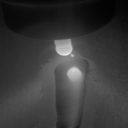

format: PNG
mode: L
size: (128, 128)


In [10]:
# Print the number of images in train, validation, and test directories
print(num_train_samples, num_val_samples, num_test_samples)

# Load an image and print image metadata
from PIL import Image
sample_img_path = list_files(os.path.join(proj_dir, TRAIN_DIR))[0]

sample_img = Image.open(sample_img_path)
display(sample_img)
print_pil_img_info(sample_img_path)

### Define model

We start with a MobileNet model and modify it for our needs.

In [27]:
# Set model training variables
batch_size = 32
tile_size = (128,128) 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Define base model
base_model = applications.InceptionResNetV2(weights = "imagenet",
                                 include_top=False,
                                 input_shape = (tile_size[0], tile_size[1], 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(tile_size) + (3,))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = layers.Flatten(name = "flatten")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation = 'softmax')(x)

model = models.Model(inputs, outputs)

base_learning_rate = 0.0001

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = optimizers.Adam(learning_rate = base_learning_rate),
              metrics = ["accuracy"])

# Uncomment the following line to see the (long) model summary
# print(model.summary())

### Define data generators

Define the data generators used during training and testing. The training data generator includes a few transformations that are applied to images during training.

In [29]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=tile_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode = 'rgb')

validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=tile_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode = 'rgb')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = tile_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False)

# plot_losses = PlotLosses()

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### Train the model

We now train the model.

import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [ ]:
len(model.trainable_variables)

In [30]:
initial_epochs = 20

tic = perf_counter()
model_hist = model.fit(
        train_generator,
        steps_per_epoch= num_train_samples // batch_size,
        epochs=initial_epochs,
        validation_data=validation_generator,
        validation_steps= num_val_samples // batch_size)
toc = perf_counter()
print(f"Trained model in {toc - tic:0.4f} seconds")

Epoch 1/20
62/62 [==============================] - 30s 366ms/step - loss: 1.0804 - accuracy: 0.4959 - val_loss: 0.6866 - val_accuracy: 0.5955
Epoch 2/20
62/62 [==============================] - 23s 370ms/step - loss: 0.9359 - accuracy: 0.5544 - val_loss: 0.5527 - val_accuracy: 0.7778
Epoch 3/20
62/62 [==============================] - 20s 313ms/step - loss: 0.8253 - accuracy: 0.6174 - val_loss: 0.4846 - val_accuracy: 0.8194
Epoch 4/20
62/62 [==============================] - 21s 332ms/step - loss: 0.7739 - accuracy: 0.6596 - val_loss: 0.4333 - val_accuracy: 0.8385
Epoch 5/20
62/62 [==============================] - 17s 277ms/step - loss: 0.7006 - accuracy: 0.6865 - val_loss: 0.4035 - val_accuracy: 0.8472
Epoch 6/20
62/62 [==============================] - 19s 297ms/step - loss: 0.6557 - accuracy: 0.7205 - val_loss: 0.3769 - val_accuracy: 0.8594
Epoch 7/20
62/62 [==============================] - 15s 242ms/step - loss: 0.6451 - accuracy: 0.7327 - val_loss: 0.3670 - val_accuracy: 0.8524

### Plot training history and check model performance

We plot the training and validation set accuracy over the training epochs. We also calculate the accuracy and Matthews correlation coefficient on the test dataset.

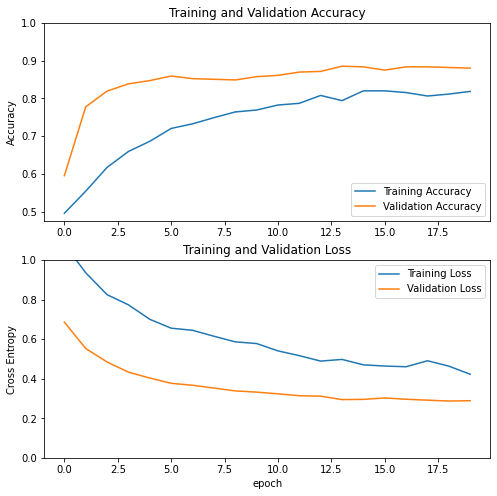


Model performance on test dataset:

Confusion Matrix:
[[266  34]
 [ 87 213]]
Accuracy: 0.7983
MCC:      0.6062


In [35]:
acc = model_hist.history['accuracy']
val_acc = model_hist.history['val_accuracy']

loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

y_pred = model.predict(test_generator, steps = None)
y_pred_class = np.array([np.argmax(x) for x in y_pred])
y_truth = test_generator.classes

print("\nModel performance on test dataset:")
print_performance(y_truth, y_pred_class)

In [36]:
## Fine tuning
## unfreezing base model and training on top of that

In [37]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  780


In [39]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [40]:
base_learning_rate = 0.0001

In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 53,511,698
Non-trainable params: 828,112
_________________________________________

In [43]:
len(model.trainable_variables)

426

In [44]:
initial_epochs = 20

In [46]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

tic = perf_counter()
history_fine = model.fit(train_generator,
                         steps_per_epoch= num_train_samples // batch_size,
                         epochs=total_epochs,
                         initial_epoch=model_hist.epoch[-1],
                         validation_data=validation_generator,
                         validation_steps= num_val_samples // batch_size)
toc = perf_counter()
print(f"Trained model in {toc - tic:0.4f} seconds")

Epoch 20/40
62/62 [==============================] - 59s 638ms/step - loss: 0.2474 - accuracy: 0.8999 - val_loss: 0.1480 - val_accuracy: 0.9306
Epoch 21/40
62/62 [==============================] - 37s 595ms/step - loss: 0.1623 - accuracy: 0.9451 - val_loss: 0.0777 - val_accuracy: 0.9705
Epoch 22/40
62/62 [==============================] - 37s 586ms/step - loss: 0.1118 - accuracy: 0.9624 - val_loss: 0.0744 - val_accuracy: 0.9722
Epoch 23/40
62/62 [==============================] - 36s 585ms/step - loss: 0.0826 - accuracy: 0.9700 - val_loss: 0.0535 - val_accuracy: 0.9774
Epoch 24/40
62/62 [==============================] - 36s 583ms/step - loss: 0.0613 - accuracy: 0.9807 - val_loss: 0.0531 - val_accuracy: 0.9826
Epoch 25/40
62/62 [==============================] - 36s 584ms/step - loss: 0.0564 - accuracy: 0.9837 - val_loss: 0.0400 - val_accuracy: 0.9896
Epoch 26/40
62/62 [==============================] - 36s 585ms/step - loss: 0.0434 - accuracy: 0.9868 - val_loss: 0.0350 - val_accuracy:

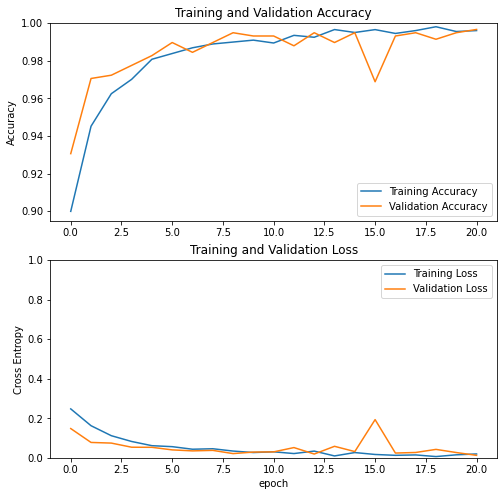


Model performance on test dataset:

Confusion Matrix:
[[270  30]
 [  6 294]]
Accuracy: 0.9400
MCC:      0.8828


In [47]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

y_pred = model.predict(test_generator, steps = None)
y_pred_class = np.array([np.argmax(x) for x in y_pred])
y_truth = test_generator.classes

print("\nModel performance on test dataset:")
print_performance(y_truth, y_pred_class)

### Convert model to ONNX and save

After converting the Keras model to ONNX, we set the `graph.name` property directly.

We also check names of the model input and output. The input name in the model must match the input name used in the `weldingPreProcessing.py` file, otherwise an error will be thrown during the scoring process.

In [ ]:
# Convert from keras to onnx
spec = (tf.TensorSpec((None, tile_size[0], tile_size[1], 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model = model, input_signature = spec)
# Set the graph name
model_proto.graph.name = 'weldingDefectModel'

# Print the model inputs and outputs
input_names = [n.name for n in model_proto.graph.input]
output_names = [n.name for n in model_proto.graph.output]
print(input_names)
print(output_names)

# Save the model
onnx.save(model_proto, "../Model/weldingDefectModel.onnx")